# Plot CDI

#### Primary Author
Chris Carey

#### Description:
This notebook plots the contact density index (CDI) for clusters and POI categories and exports data for hypothesis testing. 

#### Inputs:
```
data/cbg_attr_and_cluster_1021.csv
exports/home_weekly.csv
exports/poi_health_recategorized.csv
```

#### Ouputs:
```
exports/cdi/cbg_diff_2020.csv
exports/cdi/diff_all.csv
exports/cdi/diff_by_cluster.csv
exports/cdi/total_all.csv
exports/cdi/total_by_cluster.csv
```
 
#### Visualizations:
> Time-series plot of CDI\
> Time-series plot of change in CDI\
> Time-series plot of CDI by cluster\
> Time-series plot of CDI by POI category\

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
from matplotlib.ticker import FuncFormatter

import warnings
warnings.filterwarnings('ignore')

In [2]:
FONT_SIZE_TICKS=13
FONT_SIZE_AXIS=14
FONT_SIZE_TITLE=16
FONT_SIZE_LEGEND=14
tzinfo = pytz.timezone('US/Eastern')

In [3]:
# First week of 2019.
DATE_START = pd.to_datetime('2018-12-31 00:00:00-05:00')
# Last week of 2020.
DATE_END = pd.to_datetime('2020-01-25 00:00:00-05:00')

# First week of 2020.
DATE_START_PLOT = pd.to_datetime('2019-12-30 00:00:00-05:00')
# CUTOFF BEFORE DATA GAP
DATE_END_PLOT = pd.to_datetime('2020-11-23 00:00:00-05:00')

# Start of COVID-19 Pre-Pandemic Period
DATE_START_PRE_COVID = pd.to_datetime('2019-03-18 00:00:00-05:00')
DATE_END_PRE_COVID = pd.to_datetime('2019-11-25 00:00:00-05:00')

# Start of COVID-19 Pandemic Period
DATE_START_COVID = pd.to_datetime('2020-03-16 00:00:00-05:00')
DATE_END_COVID = pd.to_datetime('2020-11-23 00:00:00-05:00')

# First week of 2019 - 1 week.
DATE_START_ROLLING = pd.to_datetime('2018-12-24 00:00:00-05:00')
# Last week of 2020 + 1 week.
DATE_END_ROLLING = pd.to_datetime('2021-02-01 00:00:00-05:00')

In [4]:
def peek(df):
    display(df.iloc[0:3, :])
    print(len(df))

In [5]:
def repair_dates(df):
    df['date_range_start'] = pd.to_datetime(df['date_range_start'], utc=True)
    df['date_range_start'] = df['date_range_start'].dt.tz_convert('US/Eastern')

In [6]:
def smoothen(df, columns=[], N=2):
    """Returns a copy of the given dataframe with a rolling-day average of the
    given size applied to the given columns."""
    rolling_avg_df = df.copy().reset_index(drop=True)
    # An N-day rolling average with N/2 days before and N/2 after requires N+1
    # days to include the day of as well.
    rolling_avg_df[columns] = (
        rolling_avg_df[columns].rolling(N + 1, center=True).mean())
    return rolling_avg_df

def smoothen_within(df, columns=[], by=None, N=2):
    """Returns a copy of the given dataframe with a rolling-day average of the
    given size applied to the given columns within each attribute class
    determined by the given "by" attribute."""
    attr_classes = set(df[by])
    rolling_dfs = []
    for attr_class in attr_classes:
        attr_class_df = df[df[by] == attr_class]
        rolling_dfs.append(smoothen(attr_class_df, columns, N=N))
    rolling_df = pd.concat(rolling_dfs)
    rolling_df = rolling_df.sort_values(by=['date_range_start', by])
    return rolling_df

## Plot CDI

In [7]:
home_df = pd.read_csv(f'./exports/home_weekly.csv')
repair_dates(home_df)
home_df = home_df[(home_df['date_range_start'] >= DATE_START_ROLLING)]
home_df = home_df[(home_df['date_range_start'] <= DATE_END_ROLLING)]
home_df = home_df.rename(columns={'home_cbg': 'cbg'})
home_df.head()

,placekey,date_range_start,cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi
0,236-222@627-s7z-b6k,2018-12-31 00:00:00-05:00,360050001001,4,264.000000,0.250000,0.250000,20.076046
1,236-222@627-s7z-b6k,2018-12-31 00:00:00-05:00,360050210021,4,6.697436,0.013158,0.013158,0.509311
2,236-222@627-s7z-b6k,2018-12-31 00:00:00-05:00,360470285021,4,7.414691,0.007273,0.007273,0.563855
3,236-222@627-s7z-b6k,2018-12-31 00:00:00-05:00,360470488003,4,12.815287,0.025000,0.025000,0.974547
4,236-222@627-s7z-b6k,2018-12-31 00:00:00-05:00,360810232001,4,12.851064,0.045455,0.045455,0.977267


In [8]:
cdi_total_df = home_df.groupby(by=['date_range_start']).agg({
    'cdi': 'sum'
}).reset_index()
cdi_total_df = cdi_total_df.sort_values(by=['date_range_start'])
cdi_total_df = smoothen(cdi_total_df, columns=['cdi'])
cdi_total_df.to_csv('./exports/cdi/total_all.csv', index=None)
cdi_total_df.head()

,date_range_start,cdi
0,2018-12-31 00:00:00-05:00,NaN
1,2019-01-07 00:00:00-05:00,467065.008785
2,2019-01-14 00:00:00-05:00,417256.504886
3,2019-01-21 00:00:00-05:00,301070.216998
4,2019-01-28 00:00:00-05:00,323498.489399


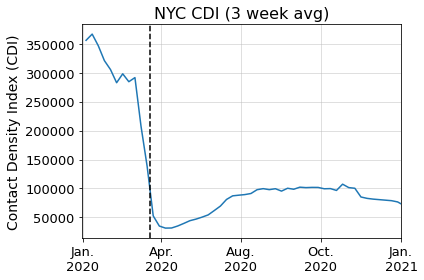

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))
cdi_2020_total_df = cdi_total_df[cdi_total_df['date_range_start'] >= datetime.datetime(2020, 1, 1, tzinfo=pytz.timezone('US/Eastern'))]
ax.plot(cdi_2020_total_df['date_range_start'], cdi_2020_total_df['cdi'])
ax.set_title('NYC CDI (3 week avg)', fontsize=FONT_SIZE_TITLE)
ax.set_ylabel('Contact Density Index (CDI)', fontsize=FONT_SIZE_AXIS)

ax.tick_params(axis='x', labelsize=FONT_SIZE_TICKS)
ax.tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
ax.axvline(datetime.datetime(2020, 3, 20), linestyle='--', color='#000')
ax.grid(color='#bdbdbd', alpha=0.6)
ax.set_xlim([datetime.datetime(2020, 1, 1, tzinfo=tzinfo), datetime.datetime(2021, 1, 1, tzinfo=tzinfo)])
ax.xaxis.set_ticks([
    datetime.datetime(2020, 1, 2, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 4, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 7, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 10, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2021, 1, 1, 0, 0, tzinfo=tzinfo),
])
ax.tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
ax.xaxis.set_ticklabels([
    'Jan.\n2020',
    'Apr.\n2020',
    'Aug.\n2020',
    'Oct.\n2020',
    'Jan.\n2021',
], fontsize=FONT_SIZE_TICKS)

plt.tight_layout()
plt.show()

In [10]:
def create_diff_df(cdi_df, diff_columns=[], keep_columns=[]):
    cdi_week_df = cdi_df
    cdi_week_df['year'] = cdi_week_df['date_range_start'].dt.year
    cdi_week_df['week'] = cdi_week_df['date_range_start'].dt.week

    # Dates are missing from December 2020!
    display(cdi_week_df.iloc[95:105])

    cdi_2020_df = cdi_week_df[cdi_week_df['year'] == 2020]
    cdi_2020_df = cdi_2020_df[cdi_2020_df['week'] >= 2]
    cdi_2020_df = cdi_2020_df[cdi_2020_df['week'] <= 52].reset_index(drop=True)
    cdi_2019_df = cdi_week_df[cdi_week_df['year'] == 2019]
    cdi_2019_df = cdi_2019_df[cdi_2019_df['week'] >= 2]
    # Remove dates that can't be compared.
    cdi_2019_df = cdi_2019_df[~cdi_2019_df['week'].isin(set([50, 51]))]
    cdi_2019_df = cdi_2019_df[cdi_2019_df['week'] <= 52].reset_index(drop=True)

    display(cdi_2019_df.head())
    display(cdi_2020_df.head())

    cdi_diff_df = pd.DataFrame()
    for keep_column in (keep_columns + ['week', 'date_range_start']):
        cdi_diff_df[keep_column] = cdi_2020_df[keep_column]
    cdi_diff_df[diff_columns] = (cdi_2020_df[diff_columns] -
                                 cdi_2019_df[diff_columns])
    cdi_diff_df = cdi_diff_df.dropna()

    display(cdi_diff_df.head())

    return cdi_diff_df

In [11]:
cdi_diff_df = create_diff_df(cdi_total_df, diff_columns=['cdi'])
cdi_diff_df.to_csv('./exports/cdi/diff_all.csv', index=None)

,date_range_start,cdi,year,week
95,2020-10-26 00:00:00-04:00,107436.692722,2020,44
96,2020-11-02 00:00:00-05:00,101543.543014,2020,45
97,2020-11-09 00:00:00-05:00,100390.873886,2020,46
98,2020-11-16 00:00:00-05:00,85313.720336,2020,47
99,2020-11-23 00:00:00-05:00,82928.796969,2020,48
100,2020-11-30 00:00:00-05:00,81622.618321,2020,49
101,2020-12-21 00:00:00-05:00,78938.996422,2020,52
102,2020-12-28 00:00:00-05:00,76792.892422,2020,53
103,2021-01-04 00:00:00-05:00,70896.354851,2021,1
104,2021-01-11 00:00:00-05:00,66483.795845,2021,2


,date_range_start,cdi,year,week
0,2019-01-07 00:00:00-05:00,467065.008785,2019,2
1,2019-01-14 00:00:00-05:00,417256.504886,2019,3
2,2019-01-21 00:00:00-05:00,301070.216998,2019,4
3,2019-01-28 00:00:00-05:00,323498.489399,2019,5
4,2019-02-04 00:00:00-05:00,333907.269703,2019,6


,date_range_start,cdi,year,week
0,2020-01-06 00:00:00-05:00,356000.705981,2020,2
1,2020-01-13 00:00:00-05:00,366765.133807,2020,3
2,2020-01-20 00:00:00-05:00,346644.476322,2020,4
3,2020-01-27 00:00:00-05:00,320948.025959,2020,5
4,2020-02-03 00:00:00-05:00,305490.215759,2020,6


,week,date_range_start,cdi
0,2,2020-01-06 00:00:00-05:00,-111064.302805
1,3,2020-01-13 00:00:00-05:00,-50491.371079
2,4,2020-01-20 00:00:00-05:00,45574.259324
3,5,2020-01-27 00:00:00-05:00,-2550.463440
4,6,2020-02-03 00:00:00-05:00,-28417.053945


No handles with labels found to put in legend.


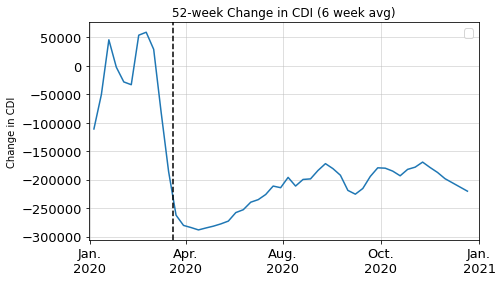

In [12]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(cdi_diff_df['date_range_start'], cdi_diff_df['cdi'])
ax.set_title('52-week Change in CDI (6 week avg)')
ax.set_ylabel('Change in CDI')

ax.tick_params(axis='x', labelsize=FONT_SIZE_TICKS)
ax.tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
ax.legend(fontsize=FONT_SIZE_LEGEND-2)
ax.axvline(datetime.datetime(2020, 3, 20), linestyle='--', color='#000')
ax.grid(color='#bdbdbd', alpha=0.6)
ax.set_xlim([datetime.datetime(2020, 1, 1, tzinfo=tzinfo), datetime.datetime(2021, 1, 1, tzinfo=tzinfo)])
ax.xaxis.set_ticks([
    datetime.datetime(2020, 1, 2, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 4, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 7, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 10, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2021, 1, 1, 0, 0, tzinfo=tzinfo),
])
ax.tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
ax.xaxis.set_ticklabels([
    'Jan.\n2020',
    'Apr.\n2020',
    'Aug.\n2020',
    'Oct.\n2020',
    'Jan.\n2021',
], fontsize=FONT_SIZE_TICKS)

plt.show()

## Plot CDI by Cluster

In [13]:
cbg_df = pd.read_csv('./data/cbg_attr_and_cluster_1021.csv')
cbg_df = cbg_df.rename(columns={
    'census_block_group': 'cbg',
    'Cluster': 'cluster',
    'Total Population': 'population',
})
cbg_df = cbg_df[['cbg', 'cluster', 'population']]
cbg_df.head()

,cbg,cluster,population
0,360050001001,2,6864
1,360050002001,2,1744
2,360050002002,2,1569
3,360050002003,3,1219
4,360050004001,3,598


In [14]:
cluster_df = cbg_df.groupby(by=['cluster']).agg({
    'population': 'sum'
}).reset_index()
cluster_df

,cluster,population
0,0,1523534
1,1,2016402
2,2,2115896
3,3,2763460


In [15]:
merge_df = home_df.merge(cbg_df, how='inner', on=['cbg'])
merge_df.head()

,placekey,date_range_start,cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi,cluster,population
0,236-222@627-s7z-b6k,2018-12-31 00:00:00-05:00,360050001001,4,264.000000,0.25,0.25,20.076046,2,6864
1,223-222@627-wg7-7h5,2018-12-31 00:00:00-05:00,360050001001,4,264.000000,0.25,0.25,25.872502,2,6864
2,22v-222@627-wg4-t5f,2018-12-31 00:00:00-05:00,360050001001,4,264.000000,0.25,0.25,22.579698,2,6864
3,zzy-222@627-wg7-7qz,2018-12-31 00:00:00-05:00,360050001001,4,264.000000,0.25,0.25,0.000000,2,6864
4,zzy-229@627-s7k-snq,2019-01-07 00:00:00-05:00,360050001001,4,203.377778,0.50,0.50,155.884113,2,6864


In [16]:
cdi_cluster_df = merge_df.groupby(by=['date_range_start', 'cluster']).agg({
    'cdi': 'sum'
}).reset_index()
cdi_cluster_df = cdi_cluster_df.merge(cluster_df, how='outer', on=['cluster'])
cdi_cluster_df = cdi_cluster_df.sort_values(by=['date_range_start', 'cluster'])
cdi_cluster_df[
    'cdi_per_capita'] = cdi_cluster_df['cdi'] / cdi_cluster_df['population']
cdi_cluster_df = smoothen_within(cdi_cluster_df,
                                 columns=['cdi', 'cdi_per_capita'],
                                 by='cluster')
cdi_cluster_df.to_csv('./exports/cdi/total_by_cluster.csv', index=None)
cdi_cluster_df.head()

,date_range_start,cluster,cdi,population,cdi_per_capita
0,2018-12-31 00:00:00-05:00,0,NaN,1523534,NaN
0,2018-12-31 00:00:00-05:00,1,NaN,2016402,NaN
0,2018-12-31 00:00:00-05:00,2,NaN,2115896,NaN
0,2018-12-31 00:00:00-05:00,3,NaN,2763460,NaN
1,2019-01-07 00:00:00-05:00,0,96633.324233,1523534,0.063427


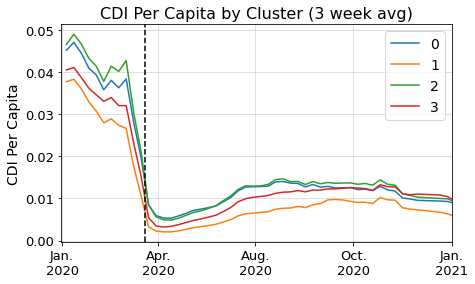

In [17]:
fig, ax = plt.subplots(figsize=(7, 4))
cdi_2020_cluster_df = cdi_cluster_df[cdi_cluster_df['date_range_start'] >= datetime.datetime(2020, 1, 1, tzinfo=pytz.timezone('US/Eastern'))]
for key, group in cdi_2020_cluster_df.groupby(by=['cluster']):
    ax.plot(group['date_range_start'], group['cdi_per_capita'], label=key)
ax.set_title('CDI Per Capita by Cluster (3 week avg)', fontsize=FONT_SIZE_TITLE)
ax.set_ylabel('CDI Per Capita', fontsize=FONT_SIZE_AXIS)

ax.tick_params(axis='x', labelsize=FONT_SIZE_TICKS)
ax.tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
ax.axvline(datetime.datetime(2020, 3, 20), linestyle='--', color='#000')
ax.grid(color='#bdbdbd', alpha=0.6)
ax.set_xlim([datetime.datetime(2020, 1, 1, tzinfo=tzinfo), datetime.datetime(2021, 1, 1, tzinfo=tzinfo)])
ax.xaxis.set_ticks([
    datetime.datetime(2020, 1, 2, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 4, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 7, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 10, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2021, 1, 1, 0, 0, tzinfo=tzinfo),
])
ax.tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
ax.xaxis.set_ticklabels([
    'Jan.\n2020',
    'Apr.\n2020',
    'Aug.\n2020',
    'Oct.\n2020',
    'Jan.\n2021',
], fontsize=FONT_SIZE_TICKS)

ax.legend(fontsize=FONT_SIZE_LEGEND)
plt.show()

In [18]:
cdi_cluster_diff_df = create_diff_df(cdi_cluster_df,
                                     diff_columns=['cdi', 'cdi_per_capita'],
                                     keep_columns=['cluster', 'cdi_per_capita'])
cdi_cluster_diff_df.to_csv('./exports/cdi/diff_by_cluster.csv', index=None)

,date_range_start,cluster,cdi,population,cdi_per_capita,year,week
23,2019-06-10 00:00:00-04:00,3,100205.435296,2763460,0.036261,2019,24
24,2019-06-17 00:00:00-04:00,0,56227.144944,1523534,0.036906,2019,25
24,2019-06-17 00:00:00-04:00,1,73080.102468,2016402,0.036243,2019,25
24,2019-06-17 00:00:00-04:00,2,76824.128203,2115896,0.036308,2019,25
24,2019-06-17 00:00:00-04:00,3,101145.251867,2763460,0.036601,2019,25
25,2019-06-24 00:00:00-04:00,0,53603.990112,1523534,0.035184,2019,26
25,2019-06-24 00:00:00-04:00,1,71016.013005,2016402,0.035219,2019,26
25,2019-06-24 00:00:00-04:00,2,74316.109176,2115896,0.035123,2019,26
25,2019-06-24 00:00:00-04:00,3,99724.692170,2763460,0.036087,2019,26
26,2019-07-01 00:00:00-04:00,0,53965.760590,1523534,0.035421,2019,27


,date_range_start,cluster,cdi,population,cdi_per_capita,year,week
0,2019-01-07 00:00:00-05:00,0,96633.324233,1523534,0.063427,2019,2
1,2019-01-07 00:00:00-05:00,1,94819.160716,2016402,0.047024,2019,2
2,2019-01-07 00:00:00-05:00,2,134400.038439,2115896,0.063519,2019,2
3,2019-01-07 00:00:00-05:00,3,141212.485397,2763460,0.051100,2019,2
4,2019-01-14 00:00:00-05:00,0,87440.256573,1523534,0.057393,2019,3


,date_range_start,cluster,cdi,population,cdi_per_capita,year,week
0,2020-01-06 00:00:00-05:00,0,68950.762831,1523534,0.045257,2020,2
1,2020-01-06 00:00:00-05:00,1,76222.563569,2016402,0.037801,2020,2
2,2020-01-06 00:00:00-05:00,2,98667.744839,2115896,0.046632,2020,2
3,2020-01-06 00:00:00-05:00,3,112159.634742,2763460,0.040587,2020,2
4,2020-01-13 00:00:00-05:00,0,71822.941531,1523534,0.047142,2020,3


,cluster,cdi_per_capita,week,date_range_start,cdi
0,0,-0.018170,2,2020-01-06 00:00:00-05:00,-27682.561402
1,1,-0.009223,2,2020-01-06 00:00:00-05:00,-18596.597147
2,2,-0.016888,2,2020-01-06 00:00:00-05:00,-35732.293601
3,3,-0.010513,2,2020-01-06 00:00:00-05:00,-29052.850655
4,0,-0.010251,3,2020-01-13 00:00:00-05:00,-15617.315042


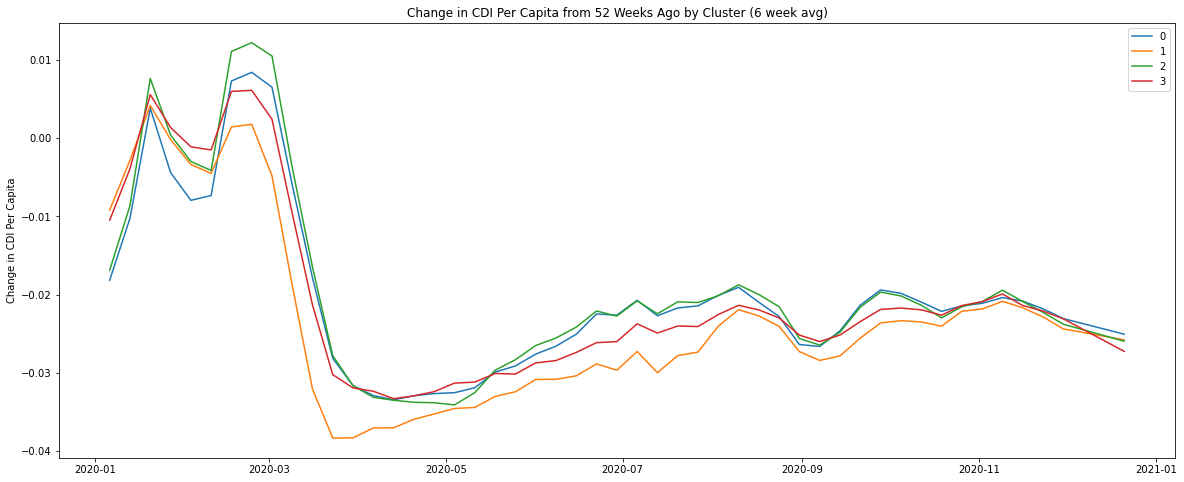

In [19]:
fig, ax = plt.subplots(figsize=(20, 8))
for key, group in cdi_cluster_diff_df.groupby(by=['cluster']):
    ax.plot(group['date_range_start'], group['cdi_per_capita'], label=key)
ax.set_title(
    'Change in CDI Per Capita from 52 Weeks Ago by Cluster (6 week avg)')
ax.set_ylabel('Change in CDI Per Capita')
ax.legend()
plt.show()

In [20]:
cdi_cbg_df = merge_df.groupby(by=['date_range_start', 'cbg']).agg({
    'cdi': 'sum'
}).reset_index()
cdi_cbg_df = cdi_cbg_df.merge(cbg_df, how='outer', on=['cbg'])
cdi_cbg_df = cdi_cbg_df.sort_values(by=['date_range_start', 'cbg'])
cdi_cbg_df[
    'cdi_per_capita'] = cdi_cbg_df['cdi'] / cdi_cbg_df['population']

In [21]:
cdi_cbg_df

,date_range_start,cbg,cdi,cluster,population,cdi_per_capita
0,2018-12-31 00:00:00-05:00,360050001001,68.528246,2,6864,0.009984
100,2018-12-31 00:00:00-05:00,360050002001,73.653522,2,1744,0.042233
208,2018-12-31 00:00:00-05:00,360050002002,46.147887,2,1569,0.029412
316,2018-12-31 00:00:00-05:00,360050002003,37.292900,3,1219,0.030593
424,2018-12-31 00:00:00-05:00,360050004001,31.675548,3,598,0.052969
...,...,...,...,...,...,...
667255,2021-02-01 00:00:00-05:00,360850319012,12.158107,3,1223,0.009941
667363,2021-02-01 00:00:00-05:00,360850319021,9.585856,2,1731,0.005538
667471,2021-02-01 00:00:00-05:00,360850319022,13.544073,0,1667,0.008125
667579,2021-02-01 00:00:00-05:00,360850319023,13.912042,0,1945,0.007153


In [22]:
cdi_cbg_df = cdi_cbg_df.rename(columns={'home_cbg': 'cbg'})
cdi_cbg_diff_df = create_diff_df(cdi_cbg_df,
                                     diff_columns=['cdi', 'cdi_per_capita'],
                                     keep_columns=['cbg'])
cdi_cbg_diff_2020_df = cdi_cbg_diff_df.groupby(by=['cbg']).agg({'cdi': 'sum'})
cdi_cbg_diff_2020_df.head()

,date_range_start,cbg,cdi,cluster,population,cdi_per_capita,year,week
10221,2018-12-31 00:00:00-05:00,360050056001,57.251213,2,956,0.059886,2018,1
10329,2018-12-31 00:00:00-05:00,360050056002,31.922409,2,601,0.053115,2018,1
10437,2018-12-31 00:00:00-05:00,360050056003,67.479809,2,722,0.093462,2018,1
10545,2018-12-31 00:00:00-05:00,360050059021,26.570871,2,866,0.030682,2018,1
10653,2018-12-31 00:00:00-05:00,360050059022,136.602531,2,1885,0.072468,2018,1
10761,2018-12-31 00:00:00-05:00,360050060001,37.805445,2,1386,0.027277,2018,1
10869,2018-12-31 00:00:00-05:00,360050061002,216.606943,0,3720,0.058228,2018,1
10977,2018-12-31 00:00:00-05:00,360050062001,30.927392,2,1092,0.028322,2018,1
11085,2018-12-31 00:00:00-05:00,360050062002,63.756762,2,1446,0.044092,2018,1
11193,2018-12-31 00:00:00-05:00,360050062003,254.864267,2,2608,0.097724,2018,1


,date_range_start,cbg,cdi,cluster,population,cdi_per_capita,year,week
0,2019-01-07 00:00:00-05:00,360050001001,156.826608,2,6864,0.022848,2019,2
1,2019-01-07 00:00:00-05:00,360050002001,41.926304,2,1744,0.024040,2019,2
2,2019-01-07 00:00:00-05:00,360050002002,64.292530,2,1569,0.040977,2019,2
3,2019-01-07 00:00:00-05:00,360050002003,84.304776,3,1219,0.069159,2019,2
4,2019-01-07 00:00:00-05:00,360050004001,16.703557,3,598,0.027932,2019,2


,date_range_start,cbg,cdi,cluster,population,cdi_per_capita,year,week
0,2020-01-06 00:00:00-05:00,360050001001,209.389274,2,6864,0.030505,2020,2
1,2020-01-06 00:00:00-05:00,360050002001,70.837399,2,1744,0.040618,2020,2
2,2020-01-06 00:00:00-05:00,360050002002,105.865440,2,1569,0.067473,2020,2
3,2020-01-06 00:00:00-05:00,360050002003,79.903352,3,1219,0.065548,2020,2
4,2020-01-06 00:00:00-05:00,360050004001,42.504528,3,598,0.071078,2020,2


,cbg,week,date_range_start,cdi,cdi_per_capita
0,360050001001,2,2020-01-06 00:00:00-05:00,52.562666,0.007658
1,360050002001,2,2020-01-06 00:00:00-05:00,28.911095,0.016577
2,360050002002,2,2020-01-06 00:00:00-05:00,41.572910,0.026496
3,360050002003,2,2020-01-06 00:00:00-05:00,-4.401424,-0.003611
4,360050004001,2,2020-01-06 00:00:00-05:00,25.800972,0.043145


,cdi
cbg,
360050001001,-219.454746
360050002001,-720.171789
360050002002,-897.445506
360050002003,-1938.630037
360050004001,-2144.795385


In [23]:
cdi_cbg_diff_2020_df.to_csv('./exports/cdi/cbg_diff_2020.csv', index=False)

In [24]:
peek(merge_df)

,placekey,date_range_start,cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi,cluster,population
0,236-222@627-s7z-b6k,2018-12-31 00:00:00-05:00,360050001001,4,264.0,0.25,0.25,20.076046,2,6864
1,223-222@627-wg7-7h5,2018-12-31 00:00:00-05:00,360050001001,4,264.0,0.25,0.25,25.872502,2,6864
2,22v-222@627-wg4-t5f,2018-12-31 00:00:00-05:00,360050001001,4,264.0,0.25,0.25,22.579698,2,6864


27486619


## Plot CDI by Borough

In [25]:
COUNTY_BRONX = 36005
COUNTY_KINGS = 36047
COUNTY_NEW_YORK = 36061
COUNTY_QUEENS = 36081
COUNTY_RICHMOND = 36085

In [26]:
360050001001 // 10000000

36005

In [27]:
cbg_df
cbg_df['borough'] = ''
cbg_df.loc[(cbg_df['cbg'] // 10000000 == COUNTY_BRONX), 'borough'] = 'Bronx'
cbg_df.loc[(cbg_df['cbg'] // 10000000 == COUNTY_KINGS), 'borough'] = 'Kings'
cbg_df.loc[(cbg_df['cbg'] // 10000000 == COUNTY_NEW_YORK), 'borough'] = 'Manhattan'
cbg_df.loc[(cbg_df['cbg'] // 10000000 == COUNTY_QUEENS), 'borough'] = 'Queens'
cbg_df.loc[(cbg_df['cbg'] // 10000000 == COUNTY_RICHMOND), 'borough'] = 'Staten Island'
cbg_df

,cbg,cluster,population,borough
0,360050001001,2,6864,Bronx
1,360050002001,2,1744,Bronx
2,360050002002,2,1569,Bronx
3,360050002003,3,1219,Bronx
4,360050004001,3,598,Bronx
...,...,...,...,...
6216,360850319012,3,1223,Staten Island
6217,360850319021,2,1731,Staten Island
6218,360850319022,0,1667,Staten Island
6219,360850319023,0,1945,Staten Island


In [28]:
borough_df = merge_df.copy()
borough_df['borough'] = ''
borough_df.loc[(borough_df['cbg'] // 10000000 == COUNTY_BRONX), 'borough'] = 'Bronx'
borough_df.loc[(borough_df['cbg'] // 10000000 == COUNTY_KINGS), 'borough'] = 'Kings'
borough_df.loc[(borough_df['cbg'] // 10000000 == COUNTY_NEW_YORK), 'borough'] = 'Manhattan'
borough_df.loc[(borough_df['cbg'] // 10000000 == COUNTY_QUEENS), 'borough'] = 'Queens'
borough_df.loc[(borough_df['cbg'] // 10000000 == COUNTY_RICHMOND), 'borough'] = 'Staten Island'
borough_df

,placekey,date_range_start,cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi,cluster,population,borough
0,236-222@627-s7z-b6k,2018-12-31 00:00:00-05:00,360050001001,4,264.000000,0.25,0.25,20.076046,2,6864,Bronx
1,223-222@627-wg7-7h5,2018-12-31 00:00:00-05:00,360050001001,4,264.000000,0.25,0.25,25.872502,2,6864,Bronx
2,22v-222@627-wg4-t5f,2018-12-31 00:00:00-05:00,360050001001,4,264.000000,0.25,0.25,22.579698,2,6864,Bronx
3,zzy-222@627-wg7-7qz,2018-12-31 00:00:00-05:00,360050001001,4,264.000000,0.25,0.25,0.000000,2,6864,Bronx
4,zzy-229@627-s7k-snq,2019-01-07 00:00:00-05:00,360050001001,4,203.377778,0.50,0.50,155.884113,2,6864,Bronx
...,...,...,...,...,...,...,...,...,...,...,...
27486614,22b-222@627-s7z-zpv,2019-11-04 00:00:00-05:00,360810050001,4,24.500000,0.50,0.50,2.221154,2,49,Queens
27486615,224-222@627-s82-4qf,2019-11-18 00:00:00-05:00,360810050001,4,24.500000,0.50,0.50,2.152027,2,49,Queens
27486616,22s-222@627-s7z-s3q,2019-11-18 00:00:00-05:00,360810050001,4,24.500000,0.50,0.50,0.819909,2,49,Queens
27486617,zzw-223@627-s82-52k,2020-10-19 00:00:00-04:00,360810050001,4,17.818182,0.50,0.50,0.000000,2,49,Queens


In [29]:
def smoothen_within(df, columns=[], by=None, N=2):
    """Returns a copy of the given dataframe with a rolling-day average of the
    given size applied to the given columns within each attribute class
    determined by the given "by" attribute."""
    attr_classes = set(df[by])
    rolling_dfs = []
    for attr_class in attr_classes:
        attr_class_df = df[df[by] == attr_class]
        rolling_dfs.append(smoothen(attr_class_df, columns, N=N))
    rolling_df = pd.concat(rolling_dfs)
    rolling_df = rolling_df.sort_values(by=['date_range_start', by])
    return rolling_df

In [30]:
borough_population_df = cbg_df.groupby(by=['borough']).agg({
    'population': 'sum'
}).reset_index()
borough_population_df

,borough,population
0,Bronx,1435068
1,Kings,2589966
2,Manhattan,1631991
3,Queens,2287377
4,Staten Island,474890


In [31]:
cdi_borough_df = borough_df.groupby(by=['date_range_start', 'borough']).agg({
    'cdi': 'sum'
}).reset_index()
cdi_borough_df = cdi_borough_df.merge(borough_population_df, how='outer', on=['borough'])
cdi_borough_df = cdi_borough_df.sort_values(by=['date_range_start', 'borough'])
cdi_borough_df[
    'cdi_per_capita'] = cdi_borough_df['cdi'] / cdi_borough_df['population']
cdi_borough_df = smoothen_within(cdi_borough_df,
                                 columns=['cdi', 'cdi_per_capita'],
                                 by='borough')
cdi_borough_df.to_csv('./exports/cdi/total_by_borough.csv', index=None)
cdi_borough_df.head()

,date_range_start,borough,cdi,population,cdi_per_capita
0,2018-12-31 00:00:00-05:00,Bronx,NaN,1435068,NaN
0,2018-12-31 00:00:00-05:00,Kings,NaN,2589966,NaN
0,2018-12-31 00:00:00-05:00,Manhattan,NaN,1631991,NaN
0,2018-12-31 00:00:00-05:00,Queens,NaN,2287377,NaN
0,2018-12-31 00:00:00-05:00,Staten Island,NaN,474890,NaN


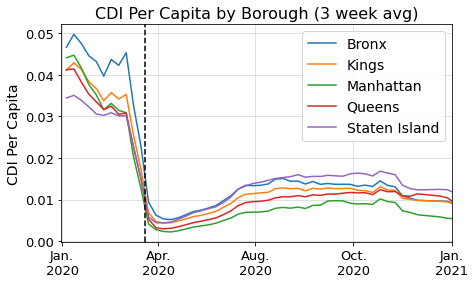

In [32]:
fig, ax = plt.subplots(figsize=(7, 4))
cdi_2020_borough_df = cdi_borough_df[cdi_borough_df['date_range_start'] >= datetime.datetime(2020, 1, 1, tzinfo=pytz.timezone('US/Eastern'))]
for key, group in cdi_2020_borough_df.groupby(by=['borough']):
    ax.plot(group['date_range_start'], group['cdi_per_capita'], label=key)
ax.set_title('CDI Per Capita by Borough (3 week avg)', fontsize=FONT_SIZE_TITLE)
ax.set_ylabel('CDI Per Capita', fontsize=FONT_SIZE_AXIS)

ax.tick_params(axis='x', labelsize=FONT_SIZE_TICKS)
ax.tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
ax.axvline(datetime.datetime(2020, 3, 20), linestyle='--', color='#000')
ax.grid(color='#bdbdbd', alpha=0.6)
ax.set_xlim([datetime.datetime(2020, 1, 1, tzinfo=tzinfo), datetime.datetime(2021, 1, 1, tzinfo=tzinfo)])
ax.xaxis.set_ticks([
    datetime.datetime(2020, 1, 2, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 4, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 7, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 10, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2021, 1, 1, 0, 0, tzinfo=tzinfo),
])
ax.tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
ax.xaxis.set_ticklabels([
    'Jan.\n2020',
    'Apr.\n2020',
    'Aug.\n2020',
    'Oct.\n2020',
    'Jan.\n2021',
], fontsize=FONT_SIZE_TICKS)

ax.legend(fontsize=FONT_SIZE_LEGEND)
plt.show()

## Plot CDI by POI Category

In [33]:
poi_df = pd.read_csv(f'./exports/poi_health_recategorized.csv')
categories = list(set(poi_df['category']))
peek(poi_df)

,placekey,cbg,naics_code,category,sub_category,location_name,area_square_feet,latitude,longitude
0,222-222@627-s94-nwk,360470395002,445210,Specialty Food Stores,Meat Markets,Broadway Meats,3177.0,40.691436,-73.924891
1,223-222@627-rw6-zfz,360050386008,445110,Supermarkets and Grocery Stores,Supermarkets and Other Grocery (except Conveni...,Foodtown,3401.0,40.876890,-73.847776
2,223-222@627-rwq-vcq,360050117001,445110,Supermarkets and Grocery Stores,Supermarkets and Other Grocery (except Conveni...,Kirsch Mushroom Company,10079.0,40.816779,-73.883401


36475


In [34]:
cdi_hc_df = merge_df.merge(poi_df[['placekey', 'category']], on=['placekey'], how='inner')
cdi_hc_df = cdi_hc_df[cdi_hc_df['category'].isin(['Supermarkets and Grocery Stores', 'Delis and Convenience Stores', 'Fast Food Restaurants'])]
peek(cdi_hc_df)

,placekey,date_range_start,cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi,cluster,population,category
543,223-222@627-wg7-7h5,2018-12-31 00:00:00-05:00,360050001001,4,264.000000,0.250000,0.250000,25.872502,2,6864,Fast Food Restaurants
544,223-222@627-wg7-7h5,2021-01-11 00:00:00-05:00,360470285021,4,21.190083,0.018182,0.018182,0.819914,2,3205,Fast Food Restaurants
545,223-222@627-wg7-7h5,2020-06-29 00:00:00-04:00,360470285021,4,18.132956,0.010782,0.010782,0.833897,2,3205,Fast Food Restaurants


6377262


In [35]:
cdi_hc_df = cdi_hc_df.groupby(by=['date_range_start', 'category']).agg({
    'cdi': 'sum'
}).reset_index()
#cdi_hc_df = cdi_hc_df.merge(category_df, how='outer', on=['category'])
cdi_hc_df = cdi_hc_df.sort_values(by=['date_range_start', 'category'])
cdi_hc_df['cdi_per_capita'] = cdi_hc_df['cdi'] / cbg_df['population'].sum()
cdi_hc_df = smoothen_within(cdi_hc_df,
                                 columns=['cdi', 'cdi_per_capita'],
                                 by='category')
peek(cdi_hc_df)

,date_range_start,category,cdi,cdi_per_capita
0,2018-12-31 00:00:00-05:00,Delis and Convenience Stores,NaN,NaN
0,2018-12-31 00:00:00-05:00,Fast Food Restaurants,NaN,NaN
0,2018-12-31 00:00:00-05:00,Supermarkets and Grocery Stores,NaN,NaN


324


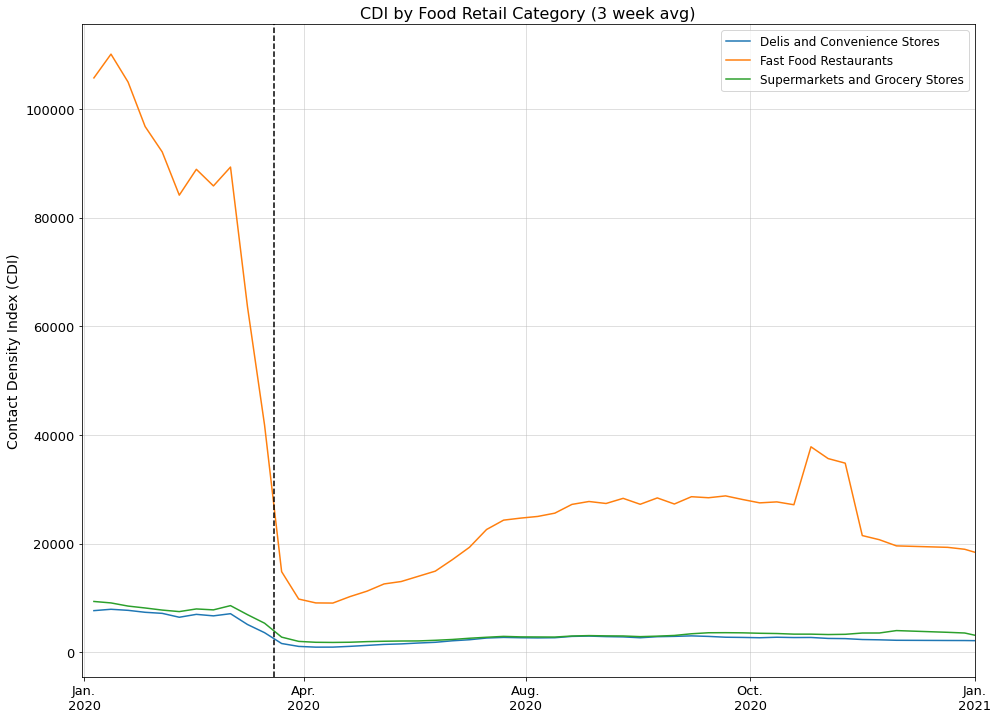

In [36]:
fig, ax = plt.subplots(figsize=(16, 12))
for key, group in cdi_hc_df.groupby(by=['category']):
    group_2020 = group[group['date_range_start'] >= datetime.datetime(2020, 1, 1, tzinfo=pytz.timezone('US/Eastern'))]
    ax.plot(group_2020['date_range_start'], group_2020['cdi'], label=key)
ax.set_title('CDI by Food Retail Category (3 week avg)', fontsize=FONT_SIZE_TITLE)
ax.set_ylabel('Contact Density Index (CDI)', fontsize=FONT_SIZE_AXIS)

ax.tick_params(axis='x', labelsize=FONT_SIZE_TICKS)
ax.tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
ax.legend(fontsize=FONT_SIZE_LEGEND-2)
ax.axvline(datetime.datetime(2020, 3, 20), linestyle='--', color='#000')
ax.grid(color='#bdbdbd', alpha=0.6)
ax.set_xlim([datetime.datetime(2020, 1, 1, tzinfo=tzinfo), datetime.datetime(2021, 1, 1, tzinfo=tzinfo)])
ax.xaxis.set_ticks([
    datetime.datetime(2020, 1, 2, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 4, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 7, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2020, 10, 1, 0, 0, tzinfo=tzinfo),
    datetime.datetime(2021, 1, 1, 0, 0, tzinfo=tzinfo),
])
ax.tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
ax.xaxis.set_ticklabels([
    'Jan.\n2020',
    'Apr.\n2020',
    'Aug.\n2020',
    'Oct.\n2020',
    'Jan.\n2021',
], fontsize=FONT_SIZE_TICKS)

plt.show()

In [37]:
# https://cran.r-project.org/web/packages/khroma/vignettes/tol.html + NYU
COLORS = [
    '#57068c', '#e0b6fc', '#825', '#173', '#dc7', '#4a9', '#c67', '#993', '#a49']
LINE_STYLES = [
    'solid',
    'dashed',
    (0, (5, 1)),
    (0, (1, 1)),
    'dashdot',
    'solid',
    (0, (3, 1, 1, 1, 1, 1)),
    'dashed',
    'dashdot',
]

In [38]:
def millions(x, pos):
    return '%1.1fM' % (x * 1e-6)

def thousands(x, pos):
    return '%1.0fK' % (x * 1e-3)

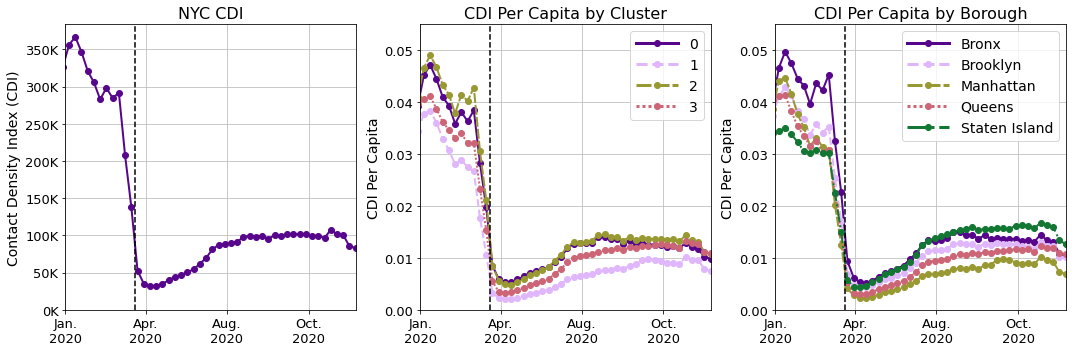

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(5 * 3, 5))

LINE_COLORS = [
    COLORS[0],
    COLORS[1],
    COLORS[7],
    COLORS[6],
    COLORS[3],
]

HC_COLORS = [
    '#117733',
    '#ddaa33',
    '#994455',
]
HC_LABELS = [
    'Supermarkets',
    'Delis',
    'Fast-Food',
]

# PLOT TOTAL
cdi_2020_total_df = cdi_total_df[
    cdi_total_df['date_range_start'] >= datetime.datetime(
        2019, 12, 30, tzinfo=pytz.timezone('US/Eastern'))]
ax[0].plot(cdi_2020_total_df['date_range_start'],
           cdi_2020_total_df['cdi'],
           color=COLORS[0],
           linewidth=2,
           marker='o',
        markersize=2,
          )
ax[0].set_title('NYC CDI', fontsize=FONT_SIZE_TITLE)
ax[0].set_ylabel('Contact Density Index (CDI)', fontsize=FONT_SIZE_AXIS)

# PLOT CLUSTER
cdi_2020_cluster_df = cdi_cluster_df[
    cdi_cluster_df['date_range_start'] >= datetime.datetime(
        2019, 12, 30, tzinfo=pytz.timezone('US/Eastern'))]
k = 0
for key, group in cdi_2020_cluster_df.groupby(by=['cluster']):
    ax[1].plot(group['date_range_start'],
               group['cdi_per_capita'],
               label=key,
               color=LINE_COLORS[k],
               linestyle=LINE_STYLES[k],
               linewidth=2,
           marker='o',
        markersize=2,
              )
    k += 1
ax[1].set_title('CDI Per Capita by Cluster', fontsize=FONT_SIZE_TITLE)
ax[1].set_ylabel('CDI Per Capita', fontsize=FONT_SIZE_AXIS)
legend = ax[1].legend(fontsize=FONT_SIZE_LEGEND, handlelength=3)
for handle in legend.legendHandles:
    handle.set_linewidth(3)

# PLOT BOROUGH
BOROUGHS = [
    'Bronx',
    'Brooklyn',
    'Manhattan',
    'Queens',
    'Staten Island',
]
cdi_2020_borough_df = cdi_borough_df[
    cdi_borough_df['date_range_start'] >= datetime.datetime(
        2019, 12, 30, tzinfo=pytz.timezone('US/Eastern'))]
k = 0
for key, group in cdi_2020_borough_df.groupby(by=['borough']):
    ax[2].plot(group['date_range_start'],
               group['cdi_per_capita'],
               label=BOROUGHS[k],
               color=LINE_COLORS[k],
               linestyle=LINE_STYLES[k],
               linewidth=2,
           marker='o',
        markersize=2,
              )
    k += 1
ax[2].set_title('CDI Per Capita by Borough', fontsize=FONT_SIZE_TITLE)
ax[2].set_ylabel('CDI Per Capita', fontsize=FONT_SIZE_AXIS)
legend = ax[2].legend(fontsize=FONT_SIZE_LEGEND, handlelength=3)
for handle in legend.legendHandles:
    handle.set_linewidth(3)

k_formatter = FuncFormatter(thousands)

ax[0].yaxis.set_major_formatter(k_formatter)

for i in range(3):
    ax[i].set_ylim(ymin=0)
    ax[i].tick_params(axis='x', labelsize=FONT_SIZE_TICKS)
    ax[i].tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
    ax[i].axvline(datetime.datetime(2020, 3, 20), linestyle='--', color='#000')
    ax[i].grid(color='#bdbdbd')

    ax[i].set_xlim(
        [datetime.datetime(2020, 1, 2, 0, 0, tzinfo=tzinfo), DATE_END_PLOT])
    ax[i].xaxis.set_ticks([
        datetime.datetime(2020, 1, 2, 0, 0, tzinfo=tzinfo),
        datetime.datetime(2020, 4, 1, 0, 0, tzinfo=tzinfo),
        datetime.datetime(2020, 7, 1, 0, 0, tzinfo=tzinfo),
        datetime.datetime(2020, 10, 1, 0, 0, tzinfo=tzinfo),
    ])
    ax[i].tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
    ax[i].xaxis.set_ticklabels([
        'Jan.\n2020',
        'Apr.\n2020',
        'Aug.\n2020',
        'Oct.\n2020',
    ],
                               fontsize=FONT_SIZE_TICKS)

ax[1].set_ylim([0, 0.055])
ax[2].set_ylim([0, 0.055])
plt.tight_layout()
plt.show()